<a href="https://colab.research.google.com/github/jos0213/kaggle/blob/main/CES_GPT4o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206969 entries, 0 to 206968
Data columns (total 26 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   id                                   206969 non-null  int64  
 1   user_id                              206969 non-null  object 
 2   age                                  206969 non-null  int64  
 3   Gender                               206969 non-null  object 
 4   Date_Registered                      206969 non-null  object 
 5   Is_current_loyalty_program_member    206969 non-null  object 
 6   loyalty_points_redeemed              206969 non-null  int64  
 7   loyalty_tier                         104902 non-null  float64
 8   Received_tier_discount_percentage    103590 non-null  float64
 9   Received_card_discount_percentage    50090 non-null   float64
 10  Received_coupon_discount_percentage  206969 non-null  int64  
 11  product_categ

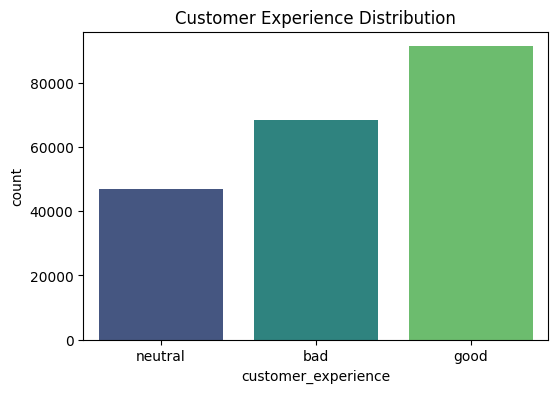

id                                          0
user_id                                     0
age                                         0
Gender                                      0
Date_Registered                             0
Is_current_loyalty_program_member           0
loyalty_points_redeemed                     0
loyalty_tier                           102067
Received_tier_discount_percentage      103379
Received_card_discount_percentage      156879
Received_coupon_discount_percentage         0
product_category                            0
Product_value                               0
transaction_id                              0
order_id                                    0
payment_method                              0
payment_datetime                            0
purchased_datetime                          0
purchase_medium                             0
final_payment                               0
released_date                               0
estimated_delivery_date           

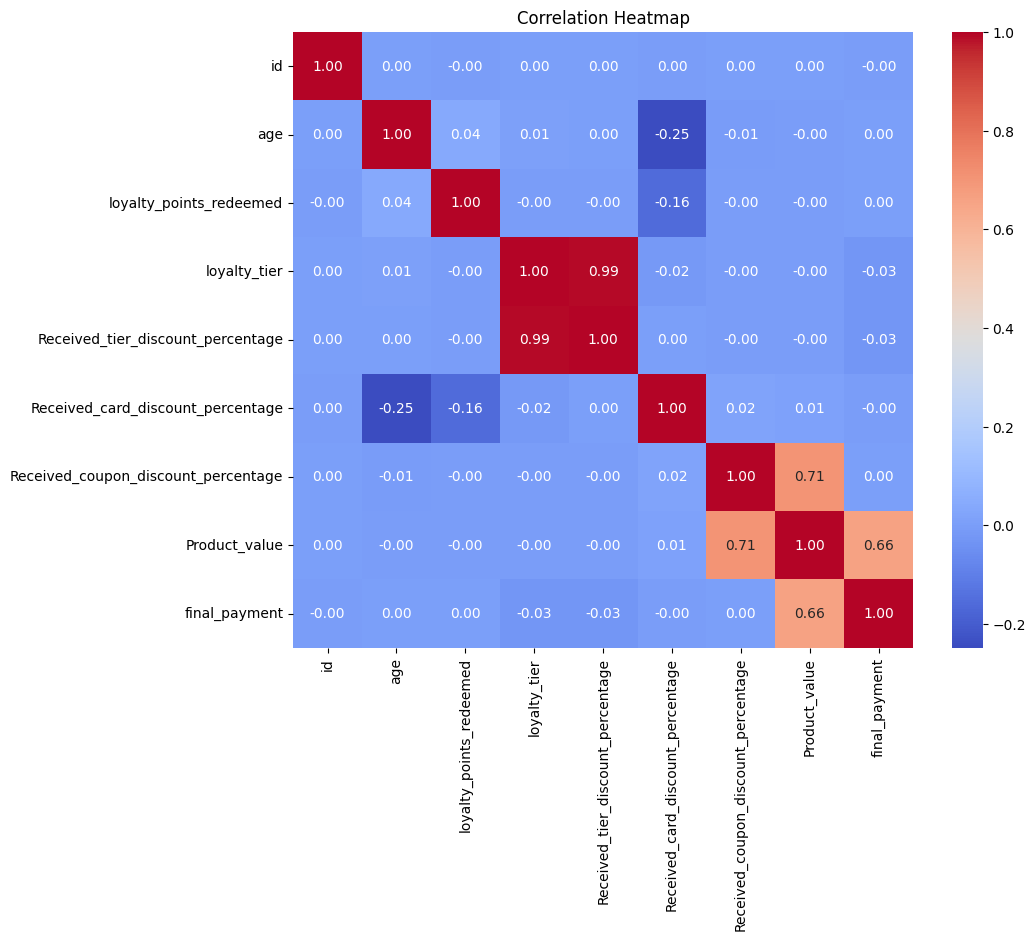

Categorical columns: ['user_id', 'Gender', 'Date_Registered', 'Is_current_loyalty_program_member', 'product_category', 'transaction_id', 'order_id', 'payment_method', 'payment_datetime', 'purchased_datetime', 'purchase_medium', 'released_date', 'estimated_delivery_date', 'received_date', 'shipping_method', 'tracking_number']


KeyboardInterrupt: 

In [19]:
# 1. 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 불러오기
# Kaggle에서 다운로드한 데이터를 사용하세요.
train = pd.read_csv('/content/drive/MyDrive/Kaggle/train_dataset.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle/test_dataset.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Kaggle/sample_submission.csv')

# 3. EDA (탐색적 데이터 분석)
print(train.info())  # 데이터 개요
print(train.describe())  # 수치형 변수 통계 요약

# 타겟 변수 분포
plt.figure(figsize=(6, 4))
sns.countplot(x='customer_experience', data=train, palette='viridis')
plt.title('Customer Experience Distribution')
plt.show()

# 결측값 확인
print(train.isnull().sum())

# 상관관계 히트맵
numeric_train = train.select_dtypes(include=[np.number])  # 수치형 데이터만 선택
numeric_train.fillna(0, inplace=True)  # 결측값을 0으로 채움
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_train.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 4. 데이터 전처리
# 라벨 인코딩 (타겟 변수 변환)
target_mapping = {'good': 0, 'neutral': 1, 'bad': 2}
train['customer_experience'] = train['customer_experience'].map(target_mapping)

# 결측값 처리 (타겟 레이블)
# 가장 빈도가 높은 값으로 결측값 채우기
most_frequent_class = train['customer_experience'].value_counts().idxmax()
train['customer_experience'].fillna(most_frequent_class, inplace=True)

# 피처와 타겟 분리
X = train.drop(columns=['customer_experience', 'id'])  # 'id'는 필요 없는 변수
y = train['customer_experience']

# 결측값 처리 (간단히 평균으로 채움)
# Select only numeric columns for filling with mean
numeric_cols = X.select_dtypes(include=np.number).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())

# Do the same for the test set
numeric_cols_test = test.select_dtypes(include=np.number).columns
test[numeric_cols_test] = test[numeric_cols_test].fillna(test[numeric_cols_test].mean())

from sklearn.preprocessing import LabelEncoder

# --- 데이터 전처리 ---
# 1. 문자열(object) 타입 열 확인
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"Categorical columns: {categorical_cols.tolist()}")

# 2. 라벨 인코딩(Label Encoding)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # 문자열로 변환 후 라벨 인코딩
    label_encoders[col] = le  # 레이블 인코더 저장 (나중에 테스트 데이터에 동일 적용)

# 테스트 데이터도 동일한 처리
for col in categorical_cols:
    if col in test.columns:
        le = label_encoders[col]
        test[col] = test[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# 3. 날짜 열 처리
date_cols = ['Date_Registered', 'payment_datetime', 'purchased_datetime',
             'released_date', 'estimated_delivery_date', 'received_date']  # 날짜 열 목록

for col in date_cols:
    if col in X.columns:
        X[col] = pd.to_datetime(X[col], errors='coerce')  # 날짜 형식으로 변환
        X[f'{col}_year'] = X[col].dt.year
        X[f'{col}_month'] = X[col].dt.month
        X[f'{col}_day'] = X[col].dt.day
        X[f'{col}_dayofweek'] = X[col].dt.dayofweek
        X.drop(columns=[col], inplace=True)  # 원본 날짜 열 삭제

# 테스트 데이터도 동일 처리
for col in date_cols:
    if col in test.columns:
        test[col] = pd.to_datetime(test[col], errors='coerce')
        test[f'{col}_year'] = test[col].dt.year
        test[f'{col}_month'] = test[col].dt.month
        test[f'{col}_day'] = test[col].dt.day
        test[f'{col}_dayofweek'] = test[col].dt.dayofweek
        test.drop(columns=[col], inplace=True)

# 4. 데이터 확인
print(X.info())  # 숫자형 데이터만 남았는지 확인
print(test.info())  # 테스트 데이터도 숫자형만 남았는지 확인

# 5. XGBoost 모델링
# 데이터 분리 (훈련 데이터와 검증 데이터)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 초기화
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# 모델 훈련
xgb_model.fit(X_train, y_train)

# 검증 데이터 평가
y_pred = xgb_model.predict(X_val)
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# 6. 테스트 데이터 예측 및 제출 파일 생성
test_data = test.drop(columns=['ID'])
test_predictions = xgb_model.predict(test_data)

# 제출 파일 생성
submission = pd.DataFrame({
    'ID': test['ID'],
    'customer_experience': test_predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")


In [12]:
print(train['customer_experience'].isnull().sum())  # 결측값 개수 확인
print(train['customer_experience'].value_counts())  # 값의 분포 확인
print(train.shape)

206969
Series([], Name: count, dtype: int64)
(206969, 26)


In [16]:
print(train['customer_experience'].head())  # map 이후 값 확인
print(train['customer_experience'].isnull().sum())  # map 이후 NaN 개수

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: customer_experience, dtype: float64
206969
